In [1]:
import pandas as pd
import numpy as np
import random
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
import torch
from transformers import MarianMTModel, MarianTokenizer, T5ForConditionalGeneration, T5Tokenizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
df = pd.read_csv('/home/Genai/project/Data/Dataset 11000 Reviews.tsv', sep='\t', header=None)
df.columns = ['sentiment', 'review']
seed_df = df.sample(n=100, random_state=42).reset_index(drop=True)
seed_df.head()

,sentiment,review
0,neg,@ anonymous urf shezad .. tum nay bhi to meri...
1,pos,ab hamin kon khilae ga bana kar balke hafsa q ...
2,pos,muskan sis ho bahi nahi girls behi patang urht...
3,neg,koi patwari issy btay agar sabit hoa tu yeh ja...
4,neg,bhot acha hoa in ka sath asi hona chaiya tha l...


In [3]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").lower()
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)

def synonym_replacement(sentence, n=2):
    words = word_tokenize(sentence)
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word.isalpha()]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) > 0:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(new_words)

def random_insertion(sentence, n=2):
    words = word_tokenize(sentence)
    for _ in range(n):
        add_word(words)
    return ' '.join(words)

def add_word(words):
    synonyms = []
    counter = 0
    while len(synonyms) < 1 and counter < 10:
        random_word = random.choice(words)
        synonyms = get_synonyms(random_word)
        counter += 1
    if len(synonyms) > 0:
        random_synonym = random.choice(synonyms)
        insert_pos = random.randint(0, len(words))
        words.insert(insert_pos, random_synonym)

def random_swap(sentence, n=2):
    words = word_tokenize(sentence)
    for _ in range(n):
        words = swap_word(words)
    return ' '.join(words)

def swap_word(words):
    if len(words) < 2:
        return words
    idx1, idx2 = random.sample(range(len(words)), 2)
    words[idx1], words[idx2] = words[idx2], words[idx1]
    return words

def random_deletion(sentence, p=0.1):
    words = word_tokenize(sentence)
    if len(words) == 1:
        return sentence
    new_words = [word for word in words if random.uniform(0,1) > p]
    if len(new_words) == 0:
        return random.choice(words)
    else:
        return ' '.join(new_words)

In [4]:
print(seed_df.columns)

Index(['sentiment', 'review'], dtype='object')


In [5]:
seed_df['synonym_replacement'] = seed_df['review'].apply(lambda x: synonym_replacement(str(x), n=2))
seed_df['random_insertion'] = seed_df['review'].apply(lambda x: random_insertion(str(x), n=2))
seed_df['random_swap'] = seed_df['review'].apply(lambda x: random_swap(str(x), n=2))
seed_df['random_deletion'] = seed_df['review'].apply(lambda x: random_deletion(str(x), p=0.1))
seed_df[['review', 'synonym_replacement', 'random_insertion', 'random_swap', 'random_deletion']].head()

,review,synonym_replacement,random_insertion,random_swap,random_deletion
0,@ anonymous urf shezad .. tum nay bhi to meri...,@ anonymous urf shezad .. tum nay bhi to meri ...,@ anonymous urf shezad breadbasket .. tum nay ...,@ anonymous urf shezad .. tum nay bhi to meri ...,@ urf shezad .. tum nay bhi to meri bohot izza...
1,ab hamin kon khilae ga bana kar balke hafsa q ...,av hamin kon khilae empire state of the south ...,ab hamin kon khilae atomic number 31 ga bana k...,ab hamin kon khilae ga bana kar balke ap q trk...,ab hamin kon khilae bana kar balke hafsa q trk...
2,muskan sis ho bahi nahi girls behi patang urht...,muskan sis ho bahi nahi girls behi patang urht...,muskan ch'i sis ho bahi nahi girls behi patang...,bhot sis ho bahi nahi girls behi patang urhtaa...,sis ho bahi nahi girls behi patang urhtaayi me...
3,koi patwari issy btay agar sabit hoa tu yeh ja...,koi patwari issy btay nutrient agar sabit hoa ...,koi patwari issy shop btay agar gaol sabit hoa...,koi patwari issy btay agar sabit jail tu yeh n...,koi patwari issy agar sabit hoa tu yeh jail ma...
4,bhot acha hoa in ka sath asi hona chaiya tha l...,bhot acha hoa indium ka sath asi hona chaiya t...,bhot acha hoa in ka sath asi inch indiana hona...,bhot acha hoa tha in sath asi hona chaiya ka l...,bhot acha hoa in sath asi hona chaiya tha lant...


In [6]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

/home/Genai/project/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
import random
import pandas as pd

# Assuming seed_df is provided with columns: 'review', 'sentiment', 'synonym_replacement'
paraphrase_examples = seed_df.sample(2, random_state=42)
negative_examples = seed_df[seed_df['sentiment'] == 'neg'].sample(2, random_state=42)
positive_examples = seed_df[seed_df['sentiment'] == 'pos'].sample(2, random_state=42)

In [8]:
def generate_paraphrase(text, num_return_sequences=1):
    prompt = "Paraphrase the following text in Roman Urdu:\n\n"
    for idx, row in paraphrase_examples.iterrows():
        prompt += f"Original: {row['review']}\nParaphrase: {row['synonym_replacement']}\n\n"
    prompt += f"Original: {text}\nParaphrase:"

    inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)
    outputs = model.generate(
        **inputs,
        max_length=150,
        num_return_sequences=num_return_sequences,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.7
    )
    paraphrases = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    return paraphrases[0] if num_return_sequences == 1 else paraphrases

def generate_conditional_text(sentiment, num_return_sequences=1):
    examples = negative_examples if sentiment == 'neg' else positive_examples
    prompt = f"Generate a {sentiment} sentiment text in Roman Urdu.\n\n"
    for idx, row in examples.iterrows():
        prompt += f"Example: {row['review']}\n\n"
    prompt += "New text:"

    inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)
    outputs = model.generate(
        **inputs,
        max_length=150,
        num_return_sequences=num_return_sequences,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.7
    )
    texts = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    return texts[0] if num_return_sequences == 1 else texts

In [9]:
seed_df['paraphrase'] = seed_df['review'].apply(lambda x: generate_paraphrase(x))

num_synthetic_per_sentiment = 50
synthetic_neg = generate_conditional_text('neg', num_return_sequences=num_synthetic_per_sentiment)
synthetic_pos = generate_conditional_text('pos', num_return_sequences=num_synthetic_per_sentiment)

conditional_synthetic_df = pd.DataFrame({
    'review': synthetic_neg + synthetic_pos,
    'sentiment': ['neg'] * num_synthetic_per_sentiment + ['pos'] * num_synthetic_per_sentiment
})

synthetic_reviews = []
synthetic_sentiments = []

for col in ['synonym_replacement', 'random_insertion', 'random_swap', 'random_deletion', 'paraphrase']:
    synthetic_reviews.extend(seed_df[col].tolist())
    synthetic_sentiments.extend(seed_df['sentiment'].tolist())

synthetic_reviews.extend(conditional_synthetic_df['review'].tolist())
synthetic_sentiments.extend(conditional_synthetic_df['sentiment'].tolist())

initial_synthetic_df = pd.DataFrame({
    'review': synthetic_reviews,
    'sentiment': synthetic_sentiments
})

In [10]:
import fasttext
import os

os.makedirs('Models/fasttext_data', exist_ok=True)
with open('Models/fasttext_data/seed_train.txt', 'w') as f:
    for idx, row in seed_df.iterrows():
        label = '__label__' + row['sentiment']
        text = row['review'].replace('\n', ' ')
        f.write(f"{label} {text}\n")

classifier = fasttext.train_supervised(input='Models/fasttext_data/seed_train.txt', epoch=25, lr=1.0, wordNgrams=2)

Read 0M words
Number of words:  1086
Number of labels: 2
Progress: 100.0% words/sec/thread:   51778 lr:  0.000000 avg.loss:  0.153752 ETA:   0h 0m 0s


In [ ]:
# 2.2 Set Up and Train RL Loop with trl library
from trl import PPOConfig, AutoModelForSeq2SeqLMWithValueHead, PPOTrainer
from torch.utils.data import Dataset
import re
import torch
from tqdm import tqdm
import gc
import math

# Ensure GPU is available and memory cleanup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
gc.collect()

# Create a model with value head for PPO
model_with_value_head = AutoModelForSeq2SeqLMWithValueHead.from_pretrained("t5-small")
model_with_value_head.to(device)

# PPO configuration optimized for 6GB VRAM with KL stability improvements
ppo_config = PPOConfig(
    model_name="t5-small",
    learning_rate=5e-6,  # Reduced learning rate for stability
    batch_size=1,
    mini_batch_size=1,
    ppo_epochs=4,
    gradient_accumulation_steps=1,
    kl_penalty="kl",  # Add KL penalty to address negative KL
    init_kl_coef=0.2,  # KL coefficient for stability
    adap_kl_ctrl=True  # Adaptive KL control
)

def get_reward(text, target_sentiment):
    # Make sure text isn't empty
    if not text or len(text.strip()) == 0:
        print("Empty response detected, assigning zero reward")
        return 0.0
        
    try:
        labels, probabilities = classifier.predict(text, k=2)
        label_prob_dict = dict(zip(labels, probabilities))
        target_label = '__label__' + target_sentiment
        reward = label_prob_dict.get(target_label, 0.0)
        
        # Thorough reward sanitization
        if not isinstance(reward, float) or math.isnan(reward) or math.isinf(reward) or reward < 0:
            print(f"Invalid reward ({reward}) for response: {text[:50]}...")
            return 0.0
            
        return reward
    except Exception as e:
        print(f"Error in reward calculation: {str(e)}, text: {text[:50]}...")
        return 0.0

def create_prompts(sentiment, num_prompts):
    examples_df = seed_df[seed_df['sentiment'] == sentiment]
    prompts = []
    for _ in range(num_prompts):
        examples = examples_df.sample(2)
        prompt = f"Generate a {sentiment} sentiment text in Roman Urdu.\n\n"
        for idx, row in examples.iterrows():
            prompt += f"Example: {row['review']}\n\n"
        prompt += "New text:"
        prompts.append(prompt)
    return prompts

# Create dataset with the required field names for PPOTrainer
class PPODataset(Dataset):
    def __init__(self, input_ids, attention_mask, prompts, sentiments):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.prompts = prompts
        self.sentiments = sentiments
        
    def __len__(self):
        return len(self.prompts)
    
    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx], 
            "prompt": self.prompts[idx],
            "sentiment": self.sentiments[idx]
        }

# Prepare prompts and targets
num_prompts_per_sentiment = 50
neg_prompts = create_prompts('neg', num_prompts_per_sentiment)
pos_prompts = create_prompts('pos', num_prompts_per_sentiment)
all_prompts = neg_prompts + pos_prompts
target_sentiments = ['neg'] * num_prompts_per_sentiment + ['pos'] * num_prompts_per_sentiment

# Tokenize prompts
tokenized_prompts = tokenizer(all_prompts, padding=True, truncation=True, return_tensors="pt")
dataset = PPODataset(
    tokenized_prompts['input_ids'], 
    tokenized_prompts['attention_mask'],
    all_prompts,
    target_sentiments
)

# Create the PPO trainer
trainer = PPOTrainer(
    config=ppo_config,
    model=model_with_value_head,
    tokenizer=tokenizer
)

# Track successful examples for debugging
successful_examples = 0
total_reward = 0.0

# PPO RL Loop
for epoch in range(4):
    print(f"Epoch {epoch + 1}/4")
    epoch_reward = 0.0
    epoch_examples = 0
    
    for idx in tqdm(range(len(dataset))):
        try:
            example = dataset[idx]
            query_tensor = example["input_ids"].unsqueeze(0).to(device)
            attention_mask = example["attention_mask"].unsqueeze(0).to(device)

            # Generate response with more conservative parameters
            with torch.no_grad():
                response_tensor = model_with_value_head.generate(
                    input_ids=query_tensor,
                    attention_mask=attention_mask,
                    max_length=100,
                    min_length=10,  # Ensure some minimal output
                    do_sample=True,
                    top_k=50,
                    top_p=0.95,
                    temperature=0.9,  # Slightly higher for more exploration
                    no_repeat_ngram_size=2  # Reduce repetition
                )

            decoded_response = tokenizer.decode(response_tensor[0], skip_special_tokens=True)
            sentiment = example["sentiment"]
            reward = get_reward(decoded_response, sentiment)
            
            # Skip very low rewards - they don't provide good training signal
            if reward < 0.05:
                print(f"Skipping example {idx} with very low reward: {reward:.4f}")
                continue
                
            rewards_tensor = torch.tensor([reward], device=device)

            # Pass lists of 1D tensors as required by PPOTrainer
            stats = trainer.step([query_tensor[0]], [response_tensor[0]], [rewards_tensor])
            
            successful_examples += 1
            total_reward += reward
            epoch_reward += reward
            epoch_examples += 1

            if idx % 10 == 0:
                print(f"Example {idx}, Reward: {reward:.4f}")
                torch.cuda.empty_cache()

        except Exception as e:
            print(f"Error on example {idx}: {str(e)}")
            torch.cuda.empty_cache()
            continue
    
    # Print epoch stats
    avg_epoch_reward = epoch_reward / max(1, epoch_examples)
    print(f"Epoch {epoch+1} complete - Avg reward: {avg_epoch_reward:.4f}")
    
    # More aggressive cleanup between epochs
    gc.collect()
    torch.cuda.empty_cache()

# Final stats
avg_reward = total_reward / max(1, successful_examples)
print(f"Training complete - {successful_examples}/{len(dataset)*4} examples processed successfully")
print(f"Average reward: {avg_reward:.4f}")

# Save the fine-tuned model
model_with_value_head.pretrained_model.save_pretrained("Models/ppo_t5_small")
tokenizer.save_pretrained("Models/ppo_t5_small")

/home/Genai/project/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/trl/models/modeling_base.py:328: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by t

Epoch 1/4


  0%|          | 0/100 [00:00<?, ?it/s]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1275: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  std_scores = data["scores"].std()
/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1302: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  stats["tokens/queries_len_std"] = torch.std(query_lens).cpu().numpy().item()
/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1305: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel)

Example 0, Reward: 0.9531


  5%|▌         | 5/100 [00:10<03:24,  2.16s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2.26 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
  7%|▋         | 7/100 [00:13<02:44,  1.76s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.27 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 11%|█         | 11/100 [00:17<02:05,  1.41s/it]

Example 10, Reward: 0.7894


 16%|█▌        | 16/100 [00:29<02:33,  1.83s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.66 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 21%|██        | 21/100 [00:40<02:42,  2.06s/it]

Example 20, Reward: 0.1750


 22%|██▏       | 22/100 [00:43<02:58,  2.29s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.57 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 27%|██▋       | 27/100 [00:49<01:52,  1.54s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.21 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 29%|██▉       | 29/100 [00:53<02:18,  1.94s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl

Example 30, Reward: 0.9275


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -4.26 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 41%|████      | 41/100 [01:13<00:55,  1.07it/s]

Example 40, Reward: 0.6146


 42%|████▏     | 42/100 [01:14<01:03,  1.09s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.95 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 44%|████▍     | 44/100 [01:18<01:17,  1.39s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.91 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 46%|████▌     | 46/100 [01:24<01:46,  1.97s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl

Skipping example 47 with very low reward: 0.0020


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.75 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 51%|█████     | 51/100 [01:30<01:15,  1.54s/it]

Example 50, Reward: 0.8186


 55%|█████▌    | 55/100 [01:39<01:36,  2.15s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.78 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 57%|█████▋    | 57/100 [01:43<01:27,  2.03s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.23 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 58%|█████▊    | 58/100 [01:44<01:16,  1.82s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl

Example 60, Reward: 0.9083


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.94 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 62%|██████▏   | 62/100 [01:53<01:25,  2.26s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -5.76 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 65%|██████▌   | 65/100 [01:59<01:18,  2.26s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL di

Example 70, Reward: 0.6387


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -16.89 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 74%|███████▍  | 74/100 [02:13<00:41,  1.59s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.07 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 77%|███████▋  | 77/100 [02:20<00:49,  2.17s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL d

Example 80, Reward: 0.9164


 86%|████████▌ | 86/100 [02:40<00:25,  1.85s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.14 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 88%|████████▊ | 88/100 [02:41<00:14,  1.19s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -5.10 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 89%|████████▉ | 89/100 [02:44<00:19,  1.75s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl

Example 90, Reward: 0.9872


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -5.11 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 96%|█████████▌| 96/100 [02:57<00:07,  1.82s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.35 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
100%|██████████| 100/100 [03:07<00:00,  1.88s/it]


Epoch 1 complete - Avg reward: 0.7914
Epoch 2/4


  1%|          | 1/100 [00:00<00:31,  3.10it/s]

Example 0, Reward: 0.3430


  9%|▉         | 9/100 [00:17<03:19,  2.19s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -12.79 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 11%|█         | 11/100 [00:20<02:48,  1.89s/it]

Example 10, Reward: 0.9104


 12%|█▏        | 12/100 [00:22<02:41,  1.83s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2.46 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 13%|█▎        | 13/100 [00:24<02:48,  1.94s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.73 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 20%|██        | 20/100 [00:37<02:13,  1.67s/it]

Skipping example 19 with very low reward: 0.0493


 21%|██        | 21/100 [00:38<01:54,  1.45s/it]

Example 20, Reward: 0.0886


 31%|███       | 31/100 [00:56<01:36,  1.40s/it]

Skipping example 30 with very low reward: 0.0279


 32%|███▏      | 32/100 [00:58<01:48,  1.60s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2.23 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 33%|███▎      | 33/100 [01:00<01:46,  1.59s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -4.33 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


Skipping example 34 with very low reward: 0.0118


 38%|███▊      | 38/100 [01:05<01:21,  1.31s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.49 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 41%|████      | 41/100 [01:10<01:40,  1.70s/it]

Example 40, Reward: 0.8326


 44%|████▍     | 44/100 [01:15<01:31,  1.63s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2.15 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 47%|████▋     | 47/100 [01:22<01:57,  2.23s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -5.69 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 51%|█████     | 51/100 [01:29<01:15,  1.53s/it]

Example 50, Reward: 0.9488


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -3.37 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 56%|█████▌    | 56/100 [01:39<01:19,  1.81s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.34 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 60%|██████    | 60/100 [01:46<01:04,  1.61s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL di

Example 60, Reward: 0.3837


 71%|███████   | 71/100 [02:01<00:34,  1.20s/it]

Example 70, Reward: 0.9483


 72%|███████▏  | 72/100 [02:02<00:34,  1.24s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -5.79 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 73%|███████▎  | 73/100 [02:04<00:37,  1.40s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -4.13 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 75%|███████▌  | 75/100 [02:07<00:36,  1.47s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl

Example 80, Reward: 0.9873


 91%|█████████ | 91/100 [02:34<00:12,  1.39s/it]

Example 90, Reward: 0.9706


 93%|█████████▎| 93/100 [02:38<00:11,  1.71s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.48 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 95%|█████████▌| 95/100 [02:42<00:08,  1.78s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -5.20 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
100%|██████████| 100/100 [02:56<00:00,  1.76s/it]


Epoch 2 complete - Avg reward: 0.7740
Epoch 3/4


  0%|          | 0/100 [00:00<?, ?it/s]

Example 0, Reward: 0.9026


  5%|▌         | 5/100 [00:04<01:25,  1.10it/s]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -5.35 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 11%|█         | 11/100 [00:15<02:48,  1.90s/it]

Example 10, Reward: 0.5770


 17%|█▋        | 17/100 [00:28<03:02,  2.20s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2.11 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 19%|█▉        | 19/100 [00:30<02:24,  1.79s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -3.63 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 21%|██        | 21/100 [00:34<02:24,  1.83s/it]

Example 20, Reward: 0.9976


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.71 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 28%|██▊       | 28/100 [00:48<02:03,  1.71s/it]

Skipping example 27 with very low reward: 0.0008


 30%|███       | 30/100 [00:50<01:27,  1.26s/it]

Skipping example 29 with very low reward: 0.0040


 31%|███       | 31/100 [00:51<01:26,  1.25s/it]

Example 30, Reward: 0.9490


 33%|███▎      | 33/100 [00:54<01:36,  1.45s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2.07 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 34%|███▍      | 34/100 [00:55<01:28,  1.35s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -3.47 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 37%|███▋      | 37/100 [01:00<01:27,  1.38s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl

Example 40, Reward: 0.8492


 51%|█████     | 51/100 [01:24<01:19,  1.63s/it]

Example 50, Reward: 0.8706


 55%|█████▌    | 55/100 [01:29<00:56,  1.25s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2.08 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 61%|██████    | 61/100 [01:40<01:02,  1.61s/it]

Example 60, Reward: 0.9946


 62%|██████▏   | 62/100 [01:41<00:59,  1.57s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2.94 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 63%|██████▎   | 63/100 [01:43<00:59,  1.60s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -3.27 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 67%|██████▋   | 67/100 [01:49<00:46,  1.41s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl

Example 70, Reward: 0.8849


 81%|████████  | 81/100 [02:09<00:35,  1.84s/it]

Example 80, Reward: 0.9724


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -4.84 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 82%|████████▏ | 82/100 [02:11<00:29,  1.63s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -5.68 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 89%|████████▉ | 89/100 [02:20<00:13,  1.24s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL di

Example 90, Reward: 0.8745


 93%|█████████▎| 93/100 [02:26<00:09,  1.38s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2.70 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 99%|█████████▉| 99/100 [02:33<00:01,  1.40s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -5.49 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
100%|██████████| 100/100 [02:34<00:00,  1.55s/it]


Epoch 3 complete - Avg reward: 0.8086
Epoch 4/4


  1%|          | 1/100 [00:01<02:50,  1.72s/it]

Example 0, Reward: 0.8405


 10%|█         | 10/100 [00:16<02:07,  1.42s/it]

Skipping example 9 with very low reward: 0.0076


 11%|█         | 11/100 [00:18<02:26,  1.64s/it]

Example 10, Reward: 0.9290


 13%|█▎        | 13/100 [00:21<02:08,  1.47s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.37 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 19%|█▉        | 19/100 [00:28<01:46,  1.31s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.30 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 21%|██        | 21/100 [00:30<01:36,  1.22s/it]

Example 20, Reward: 0.1049


 22%|██▏       | 22/100 [00:30<01:17,  1.00it/s]

Skipping example 21 with very low reward: 0.0213


/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2.79 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 30%|███       | 30/100 [00:41<01:31,  1.31s/it]

Skipping example 29 with very low reward: 0.0486


 31%|███       | 31/100 [00:42<01:25,  1.24s/it]

Example 30, Reward: 0.0565


 34%|███▍      | 34/100 [00:49<01:49,  1.66s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -15.30 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 38%|███▊      | 38/100 [00:56<01:53,  1.83s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -6.15 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 41%|████      | 41/100 [01:02<02:09,  2.19s/it]

Example 40, Reward: 0.8956


 44%|████▍     | 44/100 [01:07<01:43,  1.85s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -8.22 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 49%|████▉     | 49/100 [01:17<01:42,  2.01s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -3.40 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 51%|█████     | 51/100 [01:20<01:24,  1.73s/it]

Example 50, Reward: 0.8272


 53%|█████▎    | 53/100 [01:23<01:18,  1.67s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -2.85 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 61%|██████    | 61/100 [01:41<01:15,  1.94s/it]

Example 60, Reward: 0.9086


 62%|██████▏   | 62/100 [01:44<01:23,  2.19s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.59 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 68%|██████▊   | 68/100 [01:51<00:36,  1.15s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.64 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 71%|███████   | 71/100 [01:56<00:37,  1.29s/it]

Example 70, Reward: 0.9233


 76%|███████▌  | 76/100 [02:04<00:40,  1.69s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -5.09 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 77%|███████▋  | 77/100 [02:08<00:52,  2.28s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -3.59 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 81%|████████  | 81/100 [02:17<00:41,  2.19s/it]

Example 80, Reward: 0.9840


 83%|████████▎ | 83/100 [02:19<00:27,  1.62s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -3.95 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 87%|████████▋ | 87/100 [02:22<00:13,  1.04s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -9.70 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 91%|█████████ | 91/100 [02:29<00:13,  1.55s/it]

Example 90, Reward: 0.9625


 94%|█████████▍| 94/100 [02:33<00:08,  1.36s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -1.84 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
 99%|█████████▉| 99/100 [02:43<00:01,  1.97s/it]/home/Genai/project/.venv/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1279: UserWarning: KL divergence is starting to become negative: -13.45 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
100%|██████████| 100/100 [02:44<00:00,  1.65s/it]


Epoch 4 complete - Avg reward: 0.8199
Training complete - 391/400 examples processed successfully
Average reward: 0.7985


('ppo_t5_small/tokenizer_config.json',
 'ppo_t5_small/special_tokens_map.json',
 'ppo_t5_small/spiece.model',
 'ppo_t5_small/added_tokens.json')

In [ ]:
# 2.3 Generate Synthetic Data with PPO-Trained Model
import pandas as pd
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load the PPO-trained model and tokenizer
model = T5ForConditionalGeneration.from_pretrained("Models/ppo_t5_small").to("cuda")
tokenizer = T5Tokenizer.from_pretrained("Models/ppo_t5_small")

def generate_synthetic_text(prompt, max_length=150):
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to("cuda")
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=max_length,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.7,
        num_return_sequences=1
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def create_prompts(sentiment, num_prompts, seed_df):
    examples_df = seed_df[seed_df['sentiment'] == sentiment]
    prompts = []
    for _ in range(num_prompts):
        examples = examples_df.sample(2)
        prompt = f"Generate a {sentiment} sentiment text in Roman Urdu.\n\n"
        for idx, row in examples.iterrows():
            prompt += f"Example: {row['review']}\n\n"
        prompt += "New text:"
        prompts.append(prompt)
    return prompts

# Generate synthetic data
num_synthetic_per_sentiment = 100  # Adjust based on dataset needs
neg_prompts = create_prompts('neg', num_synthetic_per_sentiment, seed_df)
pos_prompts = create_prompts('pos', num_synthetic_per_sentiment, seed_df)

synthetic_texts = []
synthetic_labels = []

# Generate negative sentiment texts
for prompt in neg_prompts:
    text = generate_synthetic_text(prompt)
    synthetic_texts.append(text)
    synthetic_labels.append('neg')

# Generate positive sentiment texts
for prompt in pos_prompts:
    text = generate_synthetic_text(prompt)
    synthetic_texts.append(text)
    synthetic_labels.append('pos')

# Create synthetic DataFrame
synthetic_df = pd.DataFrame({
    'review': synthetic_texts,
    'sentiment': synthetic_labels
})

# Combine with seed data (optional, depending on your strategy)
augmented_df = pd.concat([seed_df, synthetic_df], ignore_index=True)

# Save augmented dataset
augmented_df.to_csv('Data/augmented_dataset.csv', index=False)
print(f"Generated {len(synthetic_df)} synthetic samples. Augmented dataset size: {len(augmented_df)}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Generated 200 synthetic samples. Augmented dataset size: 300


Loading augmented dataset...
Filtering synthetic data based on classifier confidence...


200it [00:00, 569.44it/s]


Kept 164 out of 200 synthetic examples


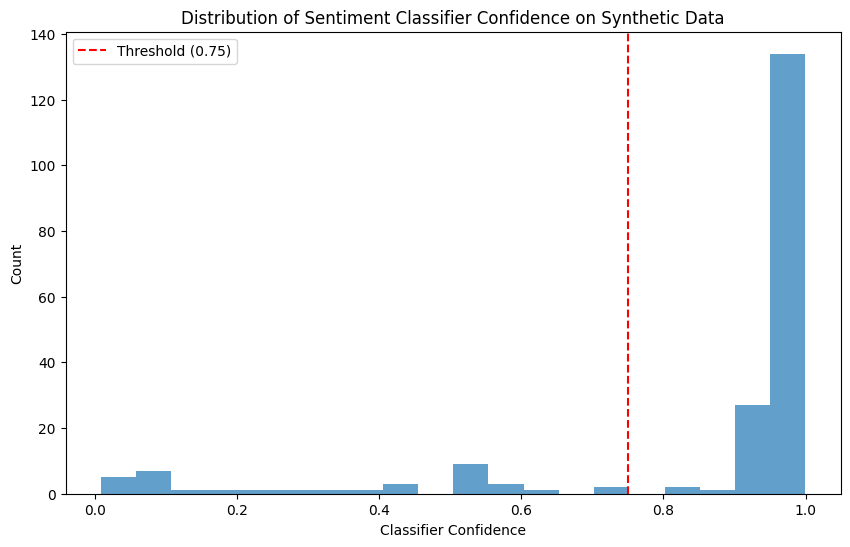

Original augmented dataset size: 300
Filtered augmented dataset size: 264


In [ ]:
# 2.4 Filter Synthetic Data by Quality
import fasttext
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

print("Loading augmented dataset...")
augmented_df = pd.read_csv('Data/augmented_dataset.csv')

# Separate seed data from synthetic data
seed_data = augmented_df.iloc[:len(seed_df)]
synthetic_data = augmented_df.iloc[len(seed_df):]

# Filter synthetic data based on classifier confidence
print("Filtering synthetic data based on classifier confidence...")
high_quality_indices = []
confidence_scores = []

for idx, row in tqdm(synthetic_data.iterrows()):
    target_label = '__label__' + row['sentiment']
    try:
        labels, probabilities = classifier.predict(row['review'], k=2)
        label_prob_dict = dict(zip(labels, probabilities))
        confidence = label_prob_dict.get(target_label, 0.0)
        confidence_scores.append(confidence)
        
        # Keep only high confidence examples (0.75 threshold)
        if confidence >= 0.75:
            high_quality_indices.append(idx)
    except Exception as e:
        continue

print(f"Kept {len(high_quality_indices)} out of {len(synthetic_data)} synthetic examples")

# Create filtered augmented dataset
filtered_synthetic_data = synthetic_data.loc[high_quality_indices]
filtered_augmented_df = pd.concat([seed_data, filtered_synthetic_data], ignore_index=True)
filtered_augmented_df.to_csv('Data/filtered_augmented_dataset.csv', index=False)

# Visualize confidence distribution
plt.figure(figsize=(10, 6))
plt.hist(confidence_scores, bins=20, alpha=0.7)
plt.axvline(x=0.75, color='r', linestyle='--', label='Threshold (0.75)')
plt.xlabel('Classifier Confidence')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Classifier Confidence on Synthetic Data')
plt.legend()
plt.savefig('Images/synthetic_data_quality.png')
plt.show()

print(f"Original augmented dataset size: {len(augmented_df)}")
print(f"Filtered augmented dataset size: {len(filtered_augmented_df)}")

In [ ]:
# 3.1 Fine-Tune and Evaluate BERT
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Load augmented dataset
augmented_df = pd.read_csv('Data/augmented_dataset.csv')

# Map sentiments to labels (pos: 1, neg: 0)
augmented_df['label'] = augmented_df['sentiment'].map({'pos': 1, 'neg': 0})

# Split into train and test sets
train_df, test_df = train_test_split(augmented_df, test_size=0.2, stratify=augmented_df['label'], random_state=42)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[['review', 'label']])
test_dataset = Dataset.from_pandas(test_df[['review', 'label']])

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2).to("cuda")

# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples['review'], padding='max_length', truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Define compute_metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {'accuracy': acc, 'f1': f1}

# Training arguments
training_args = TrainingArguments(
    output_dir='./Models/bert_finetuned',
    num_train_epochs=3,
    per_device_train_batch_size=8,  # Optimized for 6GB VRAM
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./Models/logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True  # Mixed precision for VRAM efficiency
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate on test set
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

# Save the fine-tuned model
model.save_pretrained('Models/bert_finetuned')
tokenizer.save_pretrained('Models/bert_finetuned')

# Predict on test set for detailed metrics
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
accuracy = accuracy_score(labels, preds)
f1 = f1_score(labels, preds, average='weighted')
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

2025-05-11 14:59:46.342573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-11 14:59:47.278377: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-11 14:59:47.610079: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-11 14:59:49.813875: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-11 14:59:58.636032: W tensorflow/compiler/tf2

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.667800,0.664762,0.566667,0.474191
2,0.589400,0.621488,0.616667,0.587704
3,0.383300,0.416851,0.850000,0.848531


Evaluation results: {'eval_loss': 0.4168510437011719, 'eval_accuracy': 0.85, 'eval_f1': 0.8485314685314685, 'eval_runtime': 0.5904, 'eval_samples_per_second': 101.634, 'eval_steps_per_second': 13.551, 'epoch': 3.0}
Test Accuracy: 0.8500
Test F1 Score: 0.8485


In [ ]:
# 3.1 Fine-Tune and Evaluate XLM-RoBERTa with Advanced Techniques
import pandas as pd
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load filtered augmented dataset
filtered_augmented_df = pd.read_csv('Data/augmented_dataset.csv')
filtered_augmented_df['label'] = filtered_augmented_df['sentiment'].map({'pos': 1, 'neg': 0})

# Split into train and test sets
train_df, test_df = train_test_split(filtered_augmented_df, test_size=0.2, stratify=filtered_augmented_df['label'], random_state=42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use XLM-RoBERTa instead of BERT for better multilingual performance
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[['review', 'label']])
test_dataset = Dataset.from_pandas(test_df[['review', 'label']])

# Tokenize datasets with longer max length for better coverage
def tokenize_function(examples):
    return tokenizer(examples['review'], padding='max_length', truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Define compute_metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {'accuracy': acc, 'f1': f1}

# First freeze the embedding layer and most transformer layers
for param in model.roberta.embeddings.parameters():
    param.requires_grad = False
    
for layer in model.roberta.encoder.layer[:-2]:  # Freeze all but last 2 layers
    for param in layer.parameters():
        param.requires_grad = False

# Stage 1 training arguments - train only top layers
training_args_stage1 = TrainingArguments(
    output_dir='./Models/xlm-roberta-stage1',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    lr_scheduler_type="cosine",
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./Models/logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True
)

# Early stopping callback
early_stopping = EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.01)

# Initialize Trainer
trainer_stage1 = Trainer(
    model=model,
    args=training_args_stage1,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

print("Stage 1: Training with frozen layers...")
trainer_stage1.train()

# Unfreeze all layers for fine-tuning
for param in model.parameters():
    param.requires_grad = True

# Stage 2 training arguments - fine-tune all layers with smaller learning rate
training_args_stage2 = TrainingArguments(
    output_dir='./Models/xlm-roberta-stage2',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-6,  # Much smaller learning rate
    lr_scheduler_type="cosine",
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./Models/logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True
)

# Create a new trainer for stage 2
trainer_stage2 = Trainer(
    model=model,
    args=training_args_stage2,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

print("Stage 2: Fine-tuning all layers...")
trainer_stage2.train()

# Final evaluation
eval_results = trainer_stage2.evaluate()
print(f"Evaluation results: {eval_results}")

# Save the fine-tuned model
model.save_pretrained('Models/xlm-roberta-finetuned')
tokenizer.save_pretrained('Models/xlm-roberta-finetuned')

# Get detailed metrics on test set
predictions = trainer_stage2.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
accuracy = accuracy_score(labels, preds)
f1 = f1_score(labels, preds, average='weighted')
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

/home/Genai/project/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Stage 1: Training with frozen layers...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.692500,0.691414,0.516667,0.352015
2,0.694100,0.687069,0.516667,0.352015
3,0.695900,0.650102,0.700000,0.679904


/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Stage 2: Fine-tuning all layers...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.667600,0.654142,0.733333,0.720172
2,0.656500,0.622050,0.766667,0.766667
3,0.650800,0.611281,0.750000,0.739580
4,0.640700,0.576811,0.816667,0.815897
5,0.590200,0.574209,0.833333,0.832211


Evaluation results: {'eval_loss': 0.5742085576057434, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8322109988776655, 'eval_runtime': -0.843, 'eval_samples_per_second': -71.171, 'eval_steps_per_second': -9.489, 'epoch': 5.0}
Test Accuracy: 0.8333
Test F1 Score: 0.8322


In [ ]:
# 3.2 Model Evaluation and Comparison with Baseline
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Negative', 'Positive'],
           yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('Images/confusion_matrix.png')
plt.show()

# Train baseline model on original seed data only
print("\nEvaluating baseline model (trained on seed data only)...")

# Create seed-only datasets
seed_df_with_label = seed_df.copy()
seed_df_with_label['label'] = seed_df_with_label['sentiment'].map({'pos': 1, 'neg': 0})

baseline_train, baseline_test = train_test_split(
    seed_df_with_label, test_size=0.2, stratify=seed_df_with_label['label'], random_state=42
)

baseline_train_dataset = Dataset.from_pandas(baseline_train[['review', 'label']])
baseline_test_dataset = Dataset.from_pandas(baseline_test[['review', 'label']])

# Tokenize baseline datasets
baseline_train_dataset = baseline_train_dataset.map(tokenize_function, batched=True)
baseline_test_dataset = baseline_test_dataset.map(tokenize_function, batched=True)

baseline_train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
baseline_test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Create baseline model
baseline_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

# Baseline training arguments
baseline_args = TrainingArguments(
    output_dir='./Models/baseline-model',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./Models/logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True
)

# Train baseline model
baseline_trainer = Trainer(
    model=baseline_model,
    args=baseline_args,
    train_dataset=baseline_train_dataset,
    eval_dataset=baseline_test_dataset,
    compute_metrics=compute_metrics
)

baseline_trainer.train()
baseline_results = baseline_trainer.evaluate()

# Get baseline metrics
baseline_predictions = baseline_trainer.predict(baseline_test_dataset)
baseline_preds = np.argmax(baseline_predictions.predictions, axis=1)
baseline_labels = baseline_predictions.label_ids
baseline_accuracy = accuracy_score(baseline_labels, baseline_preds)
baseline_f1 = f1_score(baseline_labels, baseline_preds, average='weighted')

# Print comparison
print("\n=== Performance Comparison ===")
print(f"Baseline (seed data only) - Accuracy: {baseline_accuracy:.4f}, F1: {baseline_f1:.4f}")
print(f"Enhanced (with synthetic) - Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
print(f"Improvement              - Accuracy: {accuracy - baseline_accuracy:.4f}, F1: {f1 - baseline_f1:.4f}")

# Find error cases for analysis
test_df_with_preds = test_df.copy()
test_df_with_preds['predicted'] = preds
test_df_with_preds['correct'] = test_df_with_preds['label'] == preds

# Print a few misclassified examples
print("\n=== Error Analysis ===")
misclassified = test_df_with_preds[~test_df_with_preds['correct']].sample(5)
for i, (_, row) in enumerate(misclassified.iterrows()):
    true_sentiment = "Positive" if row['label'] == 1 else "Negative"
    pred_sentiment = "Positive" if row['predicted'] == 1 else "Negative"
    print(f"Example {i+1}:")
    print(f"  True sentiment: {true_sentiment}")
    print(f"  Predicted sentiment: {pred_sentiment}")
    print(f"  Text: {row['review'][:100]}...")
    print()

# Plot accuracy by text length
test_df_with_preds['length'] = test_df_with_preds['review'].apply(len)
test_df_with_preds['length_group'] = pd.qcut(test_df_with_preds['length'], 4, labels=['Very Short', 'Short', 'Medium', 'Long'])
accuracy_by_length = test_df_with_preds.groupby('length_group')['correct'].mean()

plt.figure(figsize=(10, 6))
accuracy_by_length.plot(kind='bar', color='teal')
plt.title('Accuracy by Text Length')
plt.ylabel('Accuracy')
plt.xlabel('Text Length')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.savefig('Images/accuracy_by_length.png')
plt.show()

In [ ]:
# 3.3a PPO Fine-tune GPT-2 and Save Locally
from trl import PPOConfig, AutoModelForCausalLMWithValueHead, PPOTrainer
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load GPT-2 base model and tokenizer
gpt2_model_name = "gpt2"
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model_name)
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gpt2_tokenizer.padding_side = "left"

# Prepare PPO model
ppo_gpt2 = AutoModelForCausalLMWithValueHead.from_pretrained(gpt2_model_name).to(device)

ppo_config = PPOConfig(
    model_name=gpt2_model_name,
    learning_rate=5e-6,
    batch_size=1,
    mini_batch_size=1,
    ppo_epochs=4,
    gradient_accumulation_steps=1,
    kl_penalty="kl",
    init_kl_coef=0.2,
    adap_kl_ctrl=True
)

def gpt2_create_prompts(sentiment, num_prompts, seed_df):
    """
    Create prompts for GPT-2 synthetic data generation, similar to T5 prompts.
    Each prompt includes two seed examples of the target sentiment.
    """
    examples_df = seed_df[seed_df['sentiment'] == sentiment]
    prompts = []
    for _ in range(num_prompts):
        examples = examples_df.sample(2)
        prompt = f"Generate a {sentiment} sentiment text in Roman Urdu.\n\n"
        for idx, row in examples.iterrows():
            prompt += f"Example: {row['review']}\n\n"
        prompt += "New text:"
        prompts.append(prompt)
    return prompts

# Prepare prompts and targets (reuse your create_prompts logic)
num_prompts_per_sentiment = 50
neg_prompts = gpt2_create_prompts('neg', num_prompts_per_sentiment, seed_df)
pos_prompts = gpt2_create_prompts('pos', num_prompts_per_sentiment, seed_df)
all_prompts = neg_prompts + pos_prompts
target_sentiments = ['neg'] * num_prompts_per_sentiment + ['pos'] * num_prompts_per_sentiment

# Tokenize prompts
tokenized_prompts = gpt2_tokenizer(all_prompts, padding=True, truncation=True, return_tensors="pt")
class PPODataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_mask, prompts, sentiments):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.prompts = prompts
        self.sentiments = sentiments
    def __len__(self):
        return len(self.prompts)
    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "prompt": self.prompts[idx],
            "sentiment": self.sentiments[idx]
        }

ppo_dataset = PPODataset(
    tokenized_prompts['input_ids'],
    tokenized_prompts['attention_mask'],
    all_prompts,
    target_sentiments
)

ppo_trainer = PPOTrainer(
    config=ppo_config,
    model=ppo_gpt2,
    tokenizer=gpt2_tokenizer
)

def gpt2_get_reward(text, target_sentiment):
    if not text or len(text.strip()) == 0:
        return 0.0
    try:
        labels, probabilities = classifier.predict(text, k=2)
        label_prob_dict = dict(zip(labels, probabilities))
        target_label = '__label__' + target_sentiment
        reward = label_prob_dict.get(target_label, 0.0)
        return reward if isinstance(reward, float) and reward >= 0 else 0.0
    except Exception:
        return 0.0

for epoch in range(4):
    print(f"Epoch {epoch+1}/4")
    for idx in range(len(ppo_dataset)):
        example = ppo_dataset[idx]
        query_tensor = example["input_ids"].unsqueeze(0).to(device)
        attention_mask = example["attention_mask"].unsqueeze(0).to(device)
        with torch.no_grad():
            response_tensor = ppo_gpt2.generate(
                input_ids=query_tensor,
                attention_mask=attention_mask,
                max_length=query_tensor.shape[1] + 100,
                min_length=10,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.9,
                pad_token_id=gpt2_tokenizer.eos_token_id
            )
        decoded_response = gpt2_tokenizer.decode(response_tensor[0], skip_special_tokens=True)
        reward = gpt2_get_reward(decoded_response, example["sentiment"])
        if reward < 0.05:
            continue
        rewards_tensor = torch.tensor([reward], device=device)
        ppo_trainer.step([query_tensor[0]], [response_tensor[0]], [rewards_tensor])
        if idx % 10 == 0:
            torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()

# Save PPO-finetuned GPT-2 model locally
ppo_gpt2.pretrained_model.save_pretrained("Models/ppo_gpt2_small")
gpt2_tokenizer.save_pretrained("Models/ppo_gpt2_small")
print("Saved PPO-finetuned GPT-2 model to ./Models/ppo_gpt2_small")

Epoch 1/4
Epoch 2/4
Epoch 3/4
Epoch 4/4
Saved PPO-finetuned GPT-2 model to ./ppo_gpt2_small


In [ ]:
# 3.3 Generate Synthetic Data with PPO-Trained GPT-2 Model
import pandas as pd
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load PPO-trained GPT-2 model and tokenizer (replace with your actual PPO fine-tuned GPT-2 path)
gpt2_model = GPT2LMHeadModel.from_pretrained("Models/ppo_gpt2_small").to("cuda")
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("Models/ppo_gpt2_small")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token  # For padding

def gpt2_generate_synthetic_text(prompt, max_length=150):
    inputs = gpt2_tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to("cuda")
    outputs = gpt2_model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=inputs["input_ids"].shape[1] + max_length,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.7,
        num_return_sequences=1,
        pad_token_id=gpt2_tokenizer.eos_token_id
    )
    return gpt2_tokenizer.decode(outputs[0], skip_special_tokens=True)

def gpt2_create_prompts(sentiment, num_prompts, seed_df):
    examples_df = seed_df[seed_df['sentiment'] == sentiment]
    prompts = []
    for _ in range(num_prompts):
        examples = examples_df.sample(2)
        prompt = f"Generate a {sentiment} sentiment text in Roman Urdu.\n\n"
        for idx, row in examples.iterrows():
            prompt += f"Example: {row['review']}\n\n"
        prompt += "New text:"
        prompts.append(prompt)
    return prompts

# Generate synthetic data
num_synthetic_per_sentiment = 100
neg_prompts = gpt2_create_prompts('neg', num_synthetic_per_sentiment, seed_df)
pos_prompts = gpt2_create_prompts('pos', num_synthetic_per_sentiment, seed_df)

gpt2_synthetic_texts = []
gpt2_synthetic_labels = []

for prompt in neg_prompts:
    text = gpt2_generate_synthetic_text(prompt)
    gpt2_synthetic_texts.append(text)
    gpt2_synthetic_labels.append('neg')

for prompt in pos_prompts:
    text = gpt2_generate_synthetic_text(prompt)
    gpt2_synthetic_texts.append(text)
    gpt2_synthetic_labels.append('pos')

gpt2_synthetic_df = pd.DataFrame({
    'review': gpt2_synthetic_texts,
    'sentiment': gpt2_synthetic_labels
})

# Combine with seed data
gpt2_augmented_df = pd.concat([seed_df, gpt2_synthetic_df], ignore_index=True)
gpt2_augmented_df.to_csv('Data/gpt2_augmented_dataset.csv', index=False)
print(f"Generated {len(gpt2_synthetic_df)} GPT-2 synthetic samples. Augmented dataset size: {len(gpt2_augmented_df)}")

Generated 200 GPT-2 synthetic samples. Augmented dataset size: 300


Loading GPT-2 augmented dataset...
Filtering GPT-2 synthetic data based on classifier confidence...


200it [00:00, 17105.99it/s]

Kept 0 out of 200 GPT-2 synthetic examples


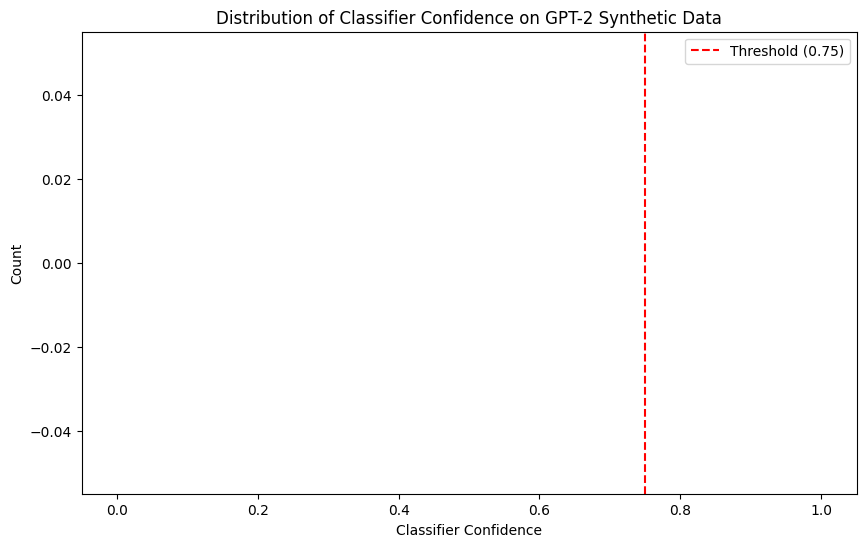

Original GPT-2 augmented dataset size: 300
Filtered GPT-2 augmented dataset size: 100


In [ ]:
# 3.4 Filter GPT-2 Synthetic Data by Quality
import fasttext
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

print("Loading GPT-2 augmented dataset...")
gpt2_augmented_df = pd.read_csv('Data/gpt2_augmented_dataset.csv')

# Separate seed data from synthetic data
seed_data = gpt2_augmented_df.iloc[:len(seed_df)]
synthetic_data = gpt2_augmented_df.iloc[len(seed_df):]

print("Filtering GPT-2 synthetic data based on classifier confidence...")
high_quality_indices = []
confidence_scores = []

for idx, row in tqdm(synthetic_data.iterrows()):
    target_label = '__label__' + row['sentiment']
    try:
        labels, probabilities = classifier.predict(row['review'], k=2)
        label_prob_dict = dict(zip(labels, probabilities))
        confidence = label_prob_dict.get(target_label, 0.0)
        confidence_scores.append(confidence)
        if confidence >= 0.75:
            high_quality_indices.append(idx)
    except Exception as e:
        continue

print(f"Kept {len(high_quality_indices)} out of {len(synthetic_data)} GPT-2 synthetic examples")

filtered_synthetic_data = synthetic_data.loc[high_quality_indices]
filtered_gpt2_augmented_df = pd.concat([seed_data, filtered_synthetic_data], ignore_index=True)
filtered_gpt2_augmented_df.to_csv('Data/gpt2_filtered_augmented_dataset.csv', index=False)

plt.figure(figsize=(10, 6))
plt.hist(confidence_scores, bins=20, alpha=0.7)
plt.axvline(x=0.75, color='r', linestyle='--', label='Threshold (0.75)')
plt.xlabel('Classifier Confidence')
plt.ylabel('Count')
plt.title('Distribution of Classifier Confidence on GPT-2 Synthetic Data')
plt.legend()
plt.savefig('Images/gpt2_synthetic_data_quality.png')
plt.show()

print(f"Original GPT-2 augmented dataset size: {len(gpt2_augmented_df)}")
print(f"Filtered GPT-2 augmented dataset size: {len(filtered_gpt2_augmented_df)}")

In [ ]:
# 3.5 Fine-Tune and Evaluate BERT on GPT-2 Synthetic Data
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Load GPT-2 augmented dataset
gpt2_augmented_df = pd.read_csv('Data/gpt2_augmented_dataset.csv')
gpt2_augmented_df['label'] = gpt2_augmented_df['sentiment'].map({'pos': 1, 'neg': 0})

# Split into train and test sets
train_df, test_df = train_test_split(gpt2_augmented_df, test_size=0.2, stratify=gpt2_augmented_df['label'], random_state=42)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[['review', 'label']])
test_dataset = Dataset.from_pandas(test_df[['review', 'label']])

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2).to("cuda")

# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples['review'], padding='max_length', truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {'accuracy': acc, 'f1': f1}

training_args = TrainingArguments(
    output_dir='./Models/bert_finetuned_gpt2',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./Models/logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

model.save_pretrained('Models/bert_finetuned_gpt2')
tokenizer.save_pretrained('Models/bert_finetuned_gpt2')

predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
accuracy = accuracy_score(labels, preds)
f1 = f1_score(labels, preds, average='weighted')
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

2025-05-12 12:07:14.635739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-12 12:07:15.855531: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-12 12:07:16.173160: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-12 12:07:18.478183: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-12 12:07:23.889133: W tensorflow/compiler/tf2

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.695400,0.683044,0.616667,0.542577
2,0.411700,0.255338,0.933333,0.932884
3,0.216800,0.350974,0.866667,0.864871


Evaluation results: {'eval_loss': 0.25533753633499146, 'eval_accuracy': 0.9333333333333333, 'eval_f1': 0.9328843995510662, 'eval_runtime': 0.6049, 'eval_samples_per_second': 99.186, 'eval_steps_per_second': 13.225, 'epoch': 3.0}
Test Accuracy: 0.9333
Test F1 Score: 0.9329


In [15]:
# 3.6 Fine-Tune and Evaluate XLM-RoBERTa on Filtered GPT-2 Synthetic Data
import pandas as pd
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load filtered GPT-2 augmented dataset
filtered_gpt2_augmented_df = pd.read_csv('Data/gpt2_filtered_augmented_dataset.csv')
filtered_gpt2_augmented_df['label'] = filtered_gpt2_augmented_df['sentiment'].map({'pos': 1, 'neg': 0})

train_df, test_df = train_test_split(filtered_gpt2_augmented_df, test_size=0.2, stratify=filtered_gpt2_augmented_df['label'], random_state=42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

train_dataset = Dataset.from_pandas(train_df[['review', 'label']])
test_dataset = Dataset.from_pandas(test_df[['review', 'label']])

def tokenize_function(examples):
    return tokenizer(examples['review'], padding='max_length', truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {'accuracy': acc, 'f1': f1}

# Freeze all but last 2 layers
for param in model.roberta.embeddings.parameters():
    param.requires_grad = False
for layer in model.roberta.encoder.layer[:-2]:
    for param in layer.parameters():
        param.requires_grad = False

training_args_stage1 = TrainingArguments(
    output_dir='./Models/xlm-roberta-gpt2-stage1',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    lr_scheduler_type="cosine",
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./Models/logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.01)

trainer_stage1 = Trainer(
    model=model,
    args=training_args_stage1,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

print("Stage 1: Training with frozen layers...")
trainer_stage1.train()

# Unfreeze all layers for fine-tuning
for param in model.parameters():
    param.requires_grad = True

training_args_stage2 = TrainingArguments(
    output_dir='./Models/xlm-roberta-gpt2-stage2',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-6,
    lr_scheduler_type="cosine",
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./Models/logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True
)

trainer_stage2 = Trainer(
    model=model,
    args=training_args_stage2,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

print("Stage 2: Fine-tuning all layers...")
trainer_stage2.train()

eval_results = trainer_stage2.evaluate()
print(f"Evaluation results: {eval_results}")

model.save_pretrained('Models/xlm-roberta-finetuned-gpt2')
tokenizer.save_pretrained('Models/xlm-roberta-finetuned-gpt2')

predictions = trainer_stage2.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
accuracy = accuracy_score(labels, preds)
f1 = f1_score(labels, preds, average='weighted')
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

/home/Genai/project/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Stage 1: Training with frozen layers...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.685500,0.688184,0.650000,0.580878
2,0.696600,0.688184,0.600000,0.493333
3,0.688000,0.687817,0.550000,0.390323


Checkpoint destination directory ./Models/xlm-roberta-gpt2-stage1/checkpoint-10 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./Models/xlm-roberta-gpt2-stage1/checkpoint-20 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./Models/xlm-roberta-gpt2-stage1/checkpoint-30 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)

Stage 2: Fine-tuning all layers...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.685100,0.688208,0.650000,0.580878
2,0.696500,0.688330,0.600000,0.493333
3,0.687400,0.688086,0.600000,0.493333


Checkpoint destination directory ./Models/xlm-roberta-gpt2-stage2/checkpoint-10 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./Models/xlm-roberta-gpt2-stage2/checkpoint-20 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./Models/xlm-roberta-gpt2-stage2/checkpoint-30 already exists and is non-empty. Saving will proceed but saved results may be invalid.


Evaluation results: {'eval_loss': 0.6882079839706421, 'eval_accuracy': 0.65, 'eval_f1': 0.5808777429467085, 'eval_runtime': 0.3571, 'eval_samples_per_second': 56.014, 'eval_steps_per_second': 8.402, 'epoch': 3.0}
Test Accuracy: 0.6500
Test F1 Score: 0.5809


In [ ]:
# 3.7 Model Evaluation and Comparison with Baseline (GPT-2 Synthetic Data)
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Negative', 'Positive'],
           yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (GPT-2 Synthetic)')
plt.savefig('Images/confusion_matrix_gpt2.png')
plt.show()

# Baseline on seed data
print("\nEvaluating baseline model (seed data only, for GPT-2 comparison)...")
seed_df_with_label = seed_df.copy()
seed_df_with_label['label'] = seed_df_with_label['sentiment'].map({'pos': 1, 'neg': 0})

baseline_train, baseline_test = train_test_split(
    seed_df_with_label, test_size=0.2, stratify=seed_df_with_label['label'], random_state=42
)

baseline_train_dataset = Dataset.from_pandas(baseline_train[['review', 'label']])
baseline_test_dataset = Dataset.from_pandas(baseline_test[['review', 'label']])

baseline_train_dataset = baseline_train_dataset.map(tokenize_function, batched=True)
baseline_test_dataset = baseline_test_dataset.map(tokenize_function, batched=True)

baseline_train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
baseline_test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

baseline_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

baseline_args = TrainingArguments(
    output_dir='./Models/baseline-model-gpt2',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True
)

baseline_trainer = Trainer(
    model=baseline_model,
    args=baseline_args,
    train_dataset=baseline_train_dataset,
    eval_dataset=baseline_test_dataset,
    compute_metrics=compute_metrics
)

baseline_trainer.train()
baseline_results = baseline_trainer.evaluate()

baseline_predictions = baseline_trainer.predict(baseline_test_dataset)
baseline_preds = np.argmax(baseline_predictions.predictions, axis=1)
baseline_labels = baseline_predictions.label_ids
baseline_accuracy = accuracy_score(baseline_labels, baseline_preds)
baseline_f1 = f1_score(baseline_labels, baseline_preds, average='weighted')

print("\n=== Performance Comparison (GPT-2 Synthetic) ===")
print(f"Baseline (seed data only) - Accuracy: {baseline_accuracy:.4f}, F1: {baseline_f1:.4f}")
print(f"Enhanced (with GPT-2 synthetic) - Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
print(f"Improvement              - Accuracy: {accuracy - baseline_accuracy:.4f}, F1: {f1 - baseline_f1:.4f}")

# Error analysis
test_df_with_preds = test_df.copy()
test_df_with_preds['predicted'] = preds
test_df_with_preds['correct'] = test_df_with_preds['label'] == preds

print("\n=== Error Analysis (GPT-2 Synthetic) ===")
misclassified = test_df_with_preds[~test_df_with_preds['correct']].sample(5)
for i, (_, row) in enumerate(misclassified.iterrows()):
    true_sentiment = "Positive" if row['label'] == 1 else "Negative"
    pred_sentiment = "Positive" if row['predicted'] == 1 else "Negative"
    print(f"Example {i+1}:")
    print(f"  True sentiment: {true_sentiment}")
    print(f"  Predicted sentiment: {pred_sentiment}")
    print(f"  Text: {row['review'][:100]}...")
    print()

test_df_with_preds['length'] = test_df_with_preds['review'].apply(len)
test_df_with_preds['length_group'] = pd.qcut(test_df_with_preds['length'], 4, labels=['Very Short', 'Short', 'Medium', 'Long'])
accuracy_by_length = test_df_with_preds.groupby('length_group')['correct'].mean()

plt.figure(figsize=(10, 6))
accuracy_by_length.plot(kind='bar', color='purple')
plt.title('Accuracy by Text Length (GPT-2 Synthetic)')
plt.ylabel('Accuracy')
plt.xlabel('Text Length')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.savefig('Images/accuracy_by_length_gpt2.png')
plt.show()

Starting GPU memory usage: 0.05 GB


/home/Genai/project/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Evaluating baseline model (seed data only, for GPT-2 comparison)...
Tokenizing datasets...


Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Creating baseline model...


/home/Genai/project/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/Genai/project/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.Da

Training baseline model...


/home/Genai/project/.venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.707200,0.702759,0.450000,0.279310
2,0.712400,0.704736,0.350000,0.289333
3,0.691000,0.709644,0.400000,0.362500


/home/Genai/project/.venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
/home/Genai/project/.venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Evaluating baseline model...



=== Performance Comparison (GPT-2 Synthetic) ===
Baseline (seed data only) - Accuracy: 0.4500, F1: 0.2793
Enhanced (with GPT-2 synthetic) - Accuracy: 0.4000, F1: 0.3879
Improvement              - Accuracy: -0.0500, F1: 0.1086

=== Error Analysis (GPT-2 Synthetic) ===
Example 1:
  True sentiment: Positive
  Predicted sentiment: Negative
  Text: ya allah hamsab ko naik hidayat atta farma hamara hukumranoo ko khulfay rashideen ka tariqa par chal...

Example 2:
  True sentiment: Negative
  Predicted sentiment: Positive
  Text: iqbal ham sharminda hein . aap ki chuti ke qatil zinda hein . ...

Example 3:
  True sentiment: Positive
  Predicted sentiment: Negative
  Text: jo logh keh rhy hain k 6gb ram huni cahiye thi un jahilo ko oneplus 3t ly laina cahiye phir .. o bha...

Example 4:
  True sentiment: Positive
  Predicted sentiment: Negative
  Text: muskan sis ho bahi nahi girls behi patang urhtaayi hy meri friend maha ko bhot achi patang uhdni att...

Example 5:
  True sentiment: Negative

/tmp/ipykernel_24133/2448992818.py:140: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_by_length = test_df_with_preds.groupby('length_group')['correct'].mean()


Final GPU memory usage: 0.05 GB


In [19]:
# Code to free GPU memory completely
import torch
import gc

# Delete any existing model variables (add specific model variables you know exist)
try:
    del model, tokenizer, trainer, model_with_value_head
    del baseline_model, baseline_trainer, ppo_gpt2, gpt2_model 
except:
    pass

# Clear cache and collect garbage
torch.cuda.empty_cache()
gc.collect()

# Check current GPU memory usage
print(f"Current GPU memory usage: {torch.cuda.memory_allocated()/1e9:.2f} GB")

Current GPU memory usage: 3.50 GB
